In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt
# add imports

<IPython.core.display.Javascript object>


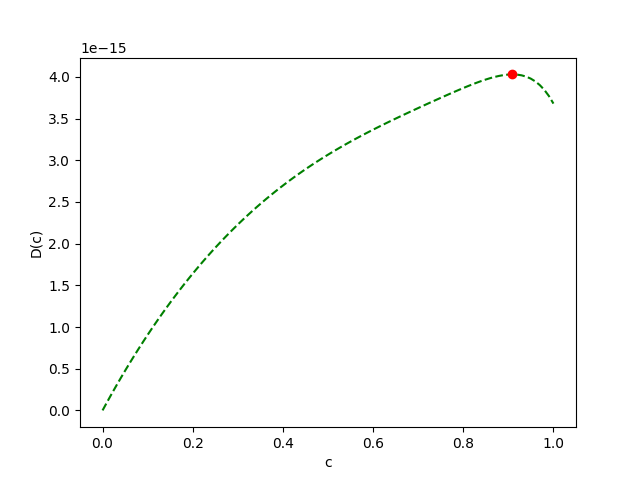

In [2]:
D_A0 = 1e-14
D_B0 = 1e-14
alpha_A = 1
alpha_B = 10
NPOINTS = 100
TEMPERATURE = 1000
KB = 1.38e-23
KT = TEMPERATURE*KB

def vectorize(func):
    """
    Vectorize decorator for python functions
    """
    def wrapper(vector):
        fn = np.vectorize(func)
        return fn(vector)
    return wrapper


@vectorize
def DA(c: float) -> float:
    return D_A0*np.exp(-alpha_A*c)

@vectorize
def DB(c: float) -> float:
    return D_B0*np.exp(-alpha_B*(1-c))


@vectorize
def Dc(c: float) -> float:
    return c*DA(c) + (1-c)*DB(c)


def plot_dc():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    max_D_index = np.argmax(D) # Find the diffusion coefficient maxima index
    fig = plt.figure('Залежність коефіцієнта дифузії від концентрації')
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    ax.clear()
    ax.set_ylabel('D(c)')
    ax.set_xlabel('c')
    ax.plot(c,D,'g--', c[max_D_index], D[max_D_index], 'ro') # show on plot D(c) and maxima of D(c)
    fig.canvas.draw()
plot_dc() 

<IPython.core.display.Javascript object>


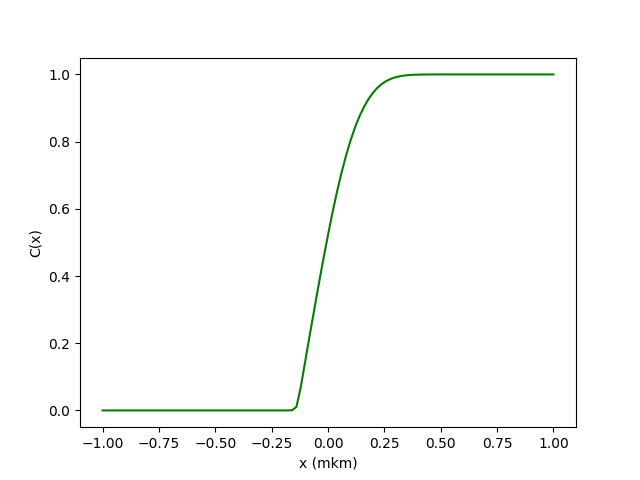


    Diffusion area distance: 2e-06 m 

    delta x: 2.000000000000002e-08 

    delta t: 0.009928260338492069 

    time: 2 s 

    
Solution completed


In [3]:
# constants for Diffusion PDE
LEFT_BOUND = -1e-6
RIGHT_BOUND = 1e-6
MAX_TIME = 2

@vectorize
def initial_c(x):
    if x>0:
        return 1
    else:
        return 0
    
def get_max_D():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    return np.max(D)

def solve_direct(TMAX: float):
    
    x = np.linspace(LEFT_BOUND,RIGHT_BOUND, NPOINTS+1) # set x vector

    DX2 = (x[1]-x[0])**2 # set dx2
    DX = x[1]-x[0]
    # calculate dt
    DT = (0.1*(DX**2))/get_max_D()
  
    
    koef = DT/DX2
    t = 0

    # initial condition
    c = np.array(initial_c(x), dtype=np.float64) 
  
    c_new = c.copy()
    curr_c, next_c = c, c
    
    fig = plt.figure('Профіль концентрації')
    ax = fig.add_subplot(111)
    fig.show()
    
    # solution  of equation
    while t < TMAX:
        
        D = Dc(c)    
        c_new[1:-1] = c[1:-1] + 0.5*koef*((D[2:]+D[1:-1])*(c[2:]-c[1:-1]) - (D[0:-2]+D[1:-1])*(c[1:-1]-c[0:-2]))
        
        c_new[0] = 0
        c_new[NPOINTS] = 1
        curr_c = c.copy()
        next_c = c_new.copy()
        
        c = c_new.copy()
        
        t+=DT
        if (t//DT) % 10 == 0:
            ax.clear()
            ax.set_ylabel('С(x)')
            ax.set_xlabel('x (mkm)')
            ax.plot(x/1e-6,c,'g-') 
            fig.canvas.draw()
        
    print(f"""
    Diffusion area distance: {RIGHT_BOUND-LEFT_BOUND} m \n
    delta x: {DX} \n
    delta t: {DT} \n
    time: {TMAX} s \n
    """)
    
    return DT, x, next_c, curr_c

dt, x, c, prev_c = solve_direct(MAX_TIME) # 5 seconds
print('Solution completed')
   

<IPython.core.display.Javascript object>


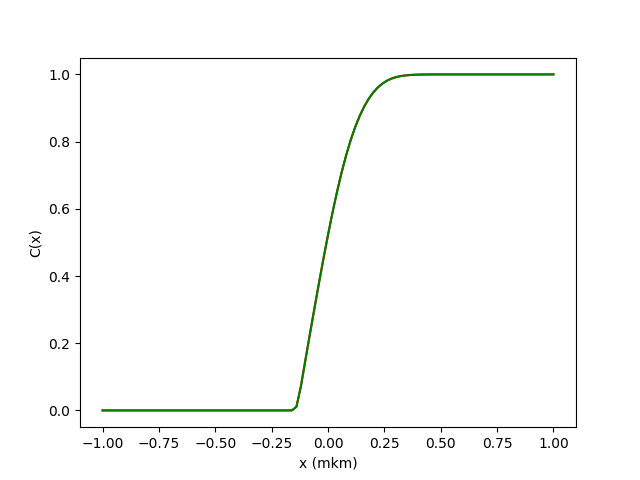

In [4]:
%matplotlib notebook
from numpy import random as rnd
NOISE_AMPLITUDE = 0 # in percent
An = NOISE_AMPLITUDE # 0.0001 percent noise

def noise_concentration_profiles(c, prev_c, An):
    rnd.seed()
    noise = An*(2*np.random.uniform(size=NPOINTS+1)-1)
    return c+noise , prev_c+noise

cn, cnprev = noise_concentration_profiles(c, prev_c, An*0.01)
        
fig = plt.figure('Cпотворений профіль концентрації ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('С(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x/1e-6,cn,'r-',x/1e-6, cnprev, 'g-') 
fig.canvas.draw()

<IPython.core.display.Javascript object>


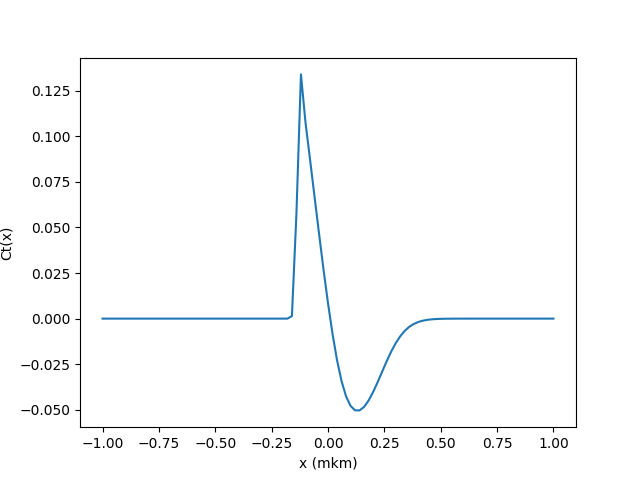

In [5]:
ct = (cn - cnprev) / dt

# plot derivative Ct
%matplotlib notebook
fig = plt.figure('Профіль першої похідної від концентрації по часу ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сt(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,ct) 
fig.canvas.draw()

<IPython.core.display.Javascript object>


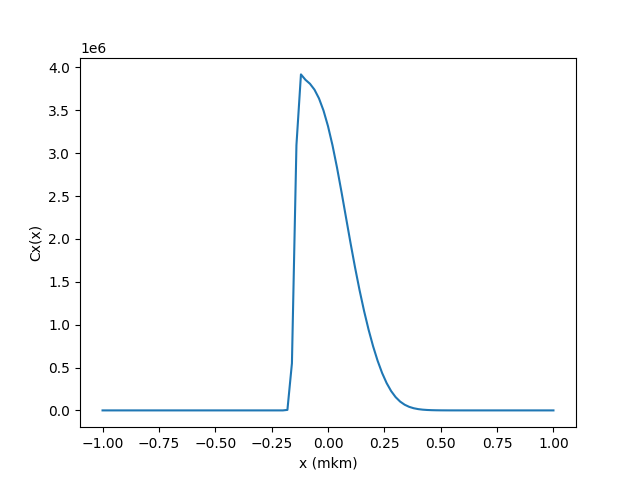

In [6]:
cx = np.zeros(NPOINTS+1, dtype=np.float64)
cx[0:-1] = (cn[1:] - cn[0:-1])/(x[1] - x[0])
cx[NPOINTS] = cx[NPOINTS-1]

# plot derivative Cx
%matplotlib notebook
fig = plt.figure('Профіль першої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сx(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,cx) 
fig.canvas.draw()

<IPython.core.display.Javascript object>


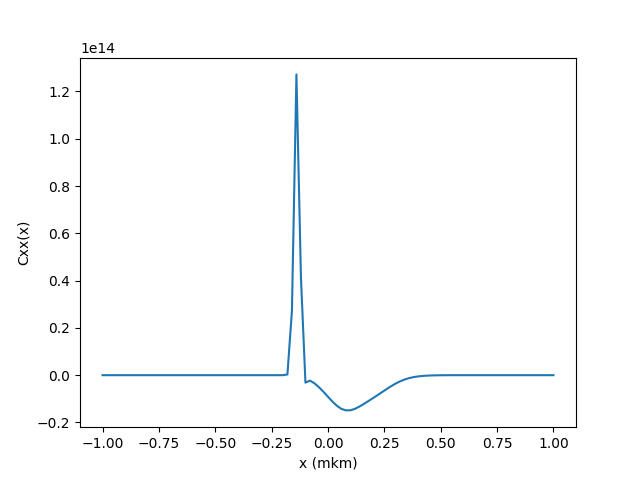

In [7]:
cxx = np.zeros(NPOINTS+1,dtype=np.float64)
cxx[1:-1] = (cn[0:-2] - 2.0*cn[1:-1] + cn[2:])/((x[1] - x[0])**2)
cxx[0] = cx[1]
cxx[NPOINTS] = cxx[NPOINTS-1]

# plot derivative Cxx
%matplotlib notebook
fig = plt.figure('Профіль другої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сxx(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,cxx) 
fig.canvas.draw()

<IPython.core.display.Javascript object>


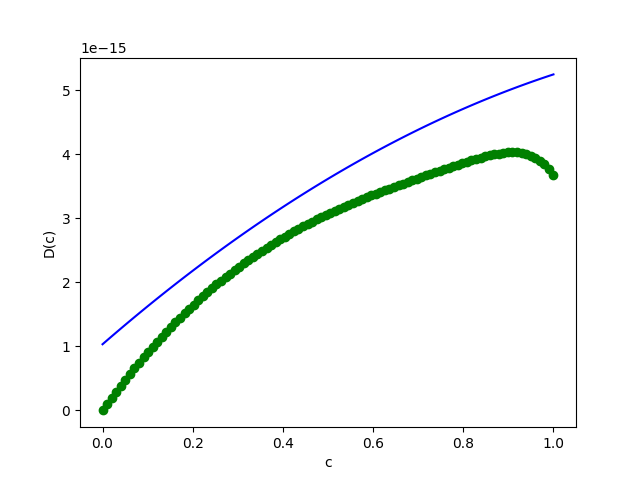

a=[ 1.03298701e-15  6.11692015e-15 -1.90476011e-15]


In [8]:
from scipy import linalg
import scipy.optimize as optimize

def d_aproxim(c,a1,a2,a3):
    return a1 + a2*c + a3*c**2

def getMaxAproximD(a1,a2,a3):
    c = np.linspace(0,1,NPOINTS)
    D = d_aproxim(c, a1,a2,a3)
    return np.max(D)
def getMinAproximD(a1,a2,a3):
    c = np.linspace(0,1,NPOINTS)
    D = d_aproxim(c, a1,a2,a3)
    return np.min(D)

def solve_direct_with_approxim(TMAX: float, a1:float, a2:float, a3: float)->tuple:
    
    x = np.linspace(LEFT_BOUND,RIGHT_BOUND, NPOINTS+1) # set x vector

    DX2 = (x[1]-x[0])**2 # set dx2
    DX = x[1]-x[0]
    # calculate dt
    DT = (0.1*(DX**2))/getMaxAproximD(a1,a2,a3)
  
    
    koef = DT/DX2
    t = 0

    # initial condition
    c = np.array(initial_c(x), dtype=np.float64) 
  
    c_new = c.copy()
    curr_c, next_c = c, c
    if getMinAproximD(a1,a2,a3) < 0:
        return DT, x, next_c, curr_c 
    # solution  of equation
    while t < TMAX:
        
        D = d_aproxim(c,a1,a2,a3)    
        c_new[1:-1] = c[1:-1] + 0.5*koef*((D[2:]+D[1:-1])*(c[2:]-c[1:-1]) - (D[0:-2]+D[1:-1])*(c[1:-1]-c[0:-2]))
        
        c_new[0] = 0
        c_new[NPOINTS] = 1
        curr_c = c.copy()
        next_c = c_new.copy()
        
        c = c_new.copy()
        
        t+=DT
    return DT, x, next_c, curr_c

alpha = 0
# calculate sums
m1 = np.sum((cxx*cn*(1-cn)*ct)/KT)

k11 = np.sum((cxx**2)*cn*(1-cn)/KT) + alpha*np.sum(cx**4)

k12 = np.sum(cxx*(cx**2)*cn*(1-cn)/KT) + np.sum((cxx**2)*(cn**2)*(1-cn)/KT) + alpha*np.sum(cn*(cx**4))

k13 = 2*np.sum((cn**2)*(1-cn)*(cx**2)/KT) + np.sum((cxx**2)*(cn**3)*(1-cn)/KT) + alpha*np.sum((cn**2)*(cx**4))


m2 = np.sum(cn*(1-cn)*(cx**2 + cn*cxx)*ct/KT)

k21 = np.sum(cn*(1-cn)*(cx**2 + cn*cxx)*cxx/KT) + alpha*np.sum(cn*(cx**4))

k22 = np.sum((cx**2)*cn*(1-cn)*(cx**2 + cn*cxx)/KT) + np.sum((cn**2)*(1-cn)*(cx**2 + cn*cxx)*cxx/KT) + alpha*np.sum((cn**2)*(cx**4))

k23 = np.sum((cx**2)*2*(cn**2)*(1-cn)*(cx**2 + cn*cxx)/KT) + np.sum(cxx*(cn**3)*(1-cn)*(cx**2 + cn*cxx)/KT) + alpha*np.sum((cn**3)*(cx**4))

m3 = np.sum(cn*(1-cn)*ct*(2*cn*(cx**2) + (cn**2)*cxx)/KT)

k31 = np.sum(cn*(1-cn)*cxx*(2*cn*(cx**2) + (cn**2)*cxx)/KT) + alpha*np.sum((cn**2)*(cx**4))
k32 = np.sum(cn*(1-cn)*(cx**2)*(2*cn*(cx**2) + (cn**2)*cxx)/KT) + np.sum((cn**2)*(1-cn)*cxx*(2*cn*(cx**2) + (cn**2)*cxx)/KT) + alpha*np.sum((cn**3)*(cx**4))
k33 = np.sum((2*cn**2)*(1-cn)*(cx**2)*(2*cn*(cx**2) + (cn**2)*cxx)/KT) + np.sum((cn**3)*(1-cn)*cxx*(2*cn*(cx**2) + (cn**2)*cxx)/KT) + alpha*np.sum((cn**4)*(cx**4))

A = np.array([[k11,k12,k13], [k21,k22,k23], [k31,k32,k33]])
B = np.array([m1,m2,m3])
a = linalg.solve(A, B)
# calculate coefficient a and b for D(c) = ac+b
c_ax = np.linspace(0,1, 100)
D_aproxim = d_aproxim(c_ax,a[0],a[1],a[2])
D_real = Dc(c_ax)

# plot aproxim
%matplotlib notebook
fig = plt.figure('Теоретична та відновлена з оберненої задачі залежність коефіцієнта дифузії ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('D(c)')
ax.set_xlabel('c')
ax.plot(c_ax,np.round(D_real,20), 'go-', c_ax, np.round(D_aproxim,20), 'b-') 

#ax.plot( c_ax, np.round(D_aproxim, 17), 'b-') 
fig.canvas.draw()
print(f"a={a}")